In [ ]:
#download weight
!gdown "https://drive.google.com/uc?id=1ioHjkU4a0iLwUuo0tDe65d7SLMUgUgbL"
!gdown "https://drive.google.com/uc?id=1Qx_Mr-wFvx_f1UlYQpZHmUdU9YUZq-Br"
!wget https://raw.githubusercontent.com/luonghuuthanhnam/ai_test_luongnam/main/task2/source/transforms.py

In [2]:
import json
import random
import transforms as T
import cv2
import numpy as np
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import os
import numpy as np
import torch
from PIL import Image
import random
from google.colab.patches import cv2_imshow
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [7]:
#Init DETECTION MODEL
def get_instance_detection_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False,
                                                                trainable_backbone_layers=3,
                                                                rpn_pre_nms_top_n_train=1000,
                                                                rpn_pre_nms_top_n_test = 1000,
                                                                rpn_post_nms_top_n_train = 1000,
                                                                rpn_post_nms_top_n_test = 1000,
                                                                rpn_nms_thresh = 0.5,
                                                                box_score_thresh = 0.5,
                                                                box_detections_per_img = 50,#
                                                                rpn_batch_size_per_image = 1000,
                                                                box_batch_size_per_image = 1000
                                                                )
    return model

def visualize_image(img, prediction):
    opencvImage = img
    if type(img) is not np.ndarray:
        opencvImage = cv2.cvtColor(np.array(opencvImage), cv2.COLOR_RGB2BGR)
        # opencvImage = np.array(opencvImage)
    for idx, bbox in enumerate(prediction[0]["boxes"]):
        bbox = np.array(bbox.tolist(), dtype=int)
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        opencvImage = cv2.rectangle(opencvImage, start_point, end_point, (0,0,255), 1)
    return opencvImage

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.2))
        transforms.append(T.RandomScale(0.7))
        transforms.append(T.RandomColor(0.3))
        transforms.append(T.Blur(prob=0.5, blur_range=(0,1)))
        transforms.append(T.GaussNoise(0.2, mean = 0, std = 10, auto= True))
    return T.Compose(transforms)


detection_model = get_instance_detection_model(2)
detection_model.load_state_dict(torch.load("state_dict_head_detector_last.pth"))
detection_model.to(device)
detection_model.eval()
detection_transform = get_transform(False)
print()

In [8]:
# Use the torchvision's implementation of ResNeXt, but add FC layer for a different number of classes (27) and a Sigmoid instead of a default Softmax.
from torch import nn
from torchvision import models
class Resnet18(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

identity_classes = ["helmet", "mask"]
model_identify = Resnet18(len(identity_classes))
model_identify.load_state_dict(torch.load("state_dict_helmet_mask_identify.pth"))
model_identify.to(device)


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

identity_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
])


import matplotlib.pyplot as plt
def identify_helmet_mask(model_identify, PIL_img, identity_transform, identity_classes):
    model_identify.eval()
    img = PIL_img
    if img.mode == "RGBA":
        img = img.convert("RGB")
    transformed_img = identity_transform(img)
    transformed_img = transformed_img.to(device)
    with torch.no_grad():
        raw_pred = model_identify(transformed_img.unsqueeze(0)).cpu().numpy()[0]
        raw_pred = np.array(raw_pred > 0.5, dtype=float)

    predicted_labels = np.array(identity_classes)[np.argwhere(raw_pred > 0)[:, 0]]
    if not len(predicted_labels):
        predicted_labels = ['no predictions']

    plt.imshow(img)
    plt.title("Predicted labels: {}".format(', '.join(predicted_labels)))
    plt.axis('off')
    plt.show()

In [9]:
def test_infer_end2end(detection_model, identify_model, img_path, detection_transform, identify_trainform, identity_classes):
    img = Image.open(img_path)
    if img.mode == "RGBA":
        img = img.convert("RGB")
    img_tensor, _ = detection_transform(img, "")
    import time
    prediction = ''
    with torch.no_grad():
        prediction = detection_model([img_tensor.to(device)])
    im  = visualize_image(img, prediction)
    cv2_imshow(im)

    for box in prediction[0]["boxes"]:
        temp_img = img.copy()
        box = box.cpu().numpy()
        ROI_img = temp_img.crop(box)
        identify_helmet_mask(identify_model, ROI_img, identify_trainform, identity_classes)


In [ ]:
!wget https://raw.githubusercontent.com/luonghuuthanhnam/ai_test_luongnam/main/task2/test_images/test1.jpg
!wget https://raw.githubusercontent.com/luonghuuthanhnam/ai_test_luongnam/main/task2/test_images/test2.jpg
!wget https://raw.githubusercontent.com/luonghuuthanhnam/ai_test_luongnam/main/task2/test_images/test3.jpg
!wget https://raw.githubusercontent.com/luonghuuthanhnam/ai_test_luongnam/main/task2/test_images/test4.jpg
!wget https://raw.githubusercontent.com/luonghuuthanhnam/ai_test_luongnam/main/task2/test_images/test5.jpg


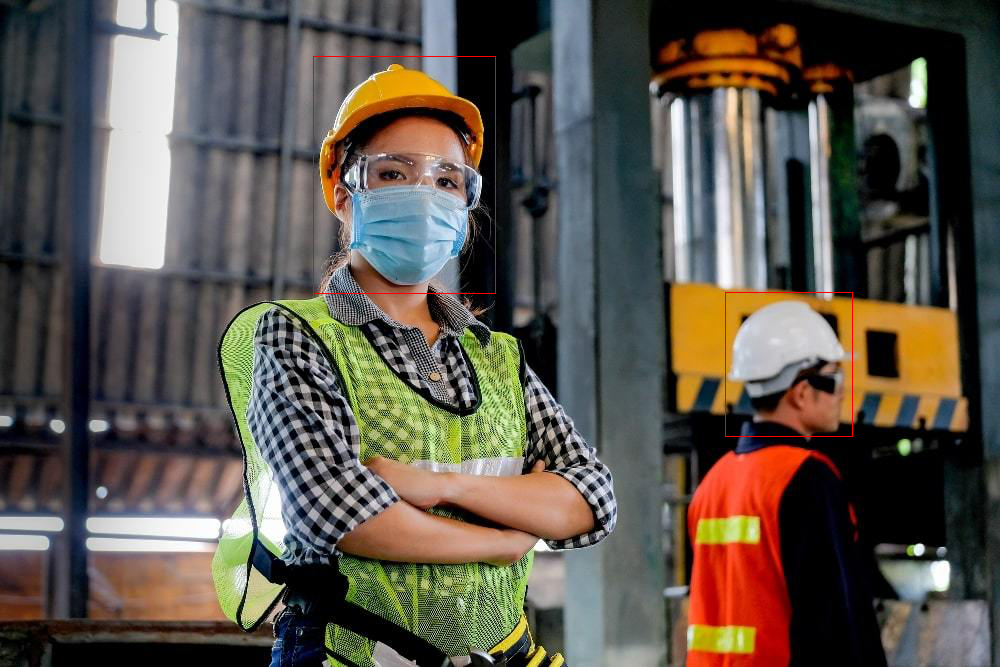

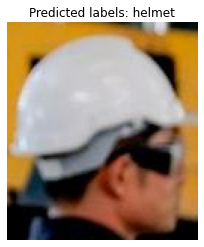

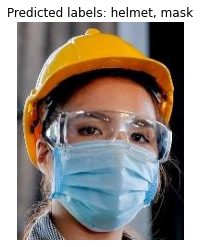

In [16]:
test_infer_end2end(detection_model, model_identify, "/content/test4.jpg", detection_transform , identity_transform, identity_classes)